Cellprofiler currently (at time of writing this, January 2025) lacks the feature to import 3D mask images that contain unique labels for each object and then retain those labels as an improted object. 
One must perform a watershed algorithm to sgement already segmented masks to create unique labels for each object.
This approach royally messes up the original segmentation and is not recommended.
Not being able to import labels into Cellprofiler is a major limitation, that subsequently limits the ability to assign parent and child relationships between objects.
For example, I want to relate a parent organoid object to its child Nuclei, and the Nuclei's child Cells, and the Cells' child cytoplasm.
To circumvent this limitation,  I have decided to write my own object relationship algorithm in Python.
This algorithm will take an organoid, nuclei, cell, and cytoplasm mask and assign parent and child relationships between the objects. 
To carry out this task I will rely on a few key assumptions:
1. There can be >= 1 organoid in the image
2. Multiple nuclei can be present in an organoid
3. One cell can be present for each nucleus
4. One cytoplasm can be present for each cell
5. The organoid is the parent of the nuclei, the nuclei is the parent of the cell, and the cell is the parent of the cytoplasm
    * The Nuclei is the parent of the cell strictly because there is a lower error rate in segmenting nuclei than cells, and thus segmented nuclei represent a more accurate representation of the number of cells than segmented cells
6. The organoid, nuclei, cell, and cytoplasm masks are masks with unique labels for each object i.e. the labels numbers are encoded in the pixel values of the mask image
7. The masks are 3D masks read in with the following dimensions: (z, y, x)


In [14]:
import argparse
import pathlib
from typing import List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import skimage
import tifffile
from skimage.measure import regionprops_table

In [19]:
def plot_max_ortho_slices(
    image: np.ndarray,
    anisotropy: Tuple[int, None] = None,
    show_plot: bool = True,
    plot_output_path: Tuple[pathlib.Path, None] = None,
) -> None:
    """
    A function to plot the maximum intensity projection of an image along the x, y, and z axes.
    Parameters
    ----------
    image : np.ndarray
        A 3D numpy array representing an image.
        The dimensions of the array should be (z, y, x).
    anisotropy : Tuple[int, None], optional
        A tuple of two integers representing the anisotropy of the image in the x and y directions.
        The default is None.
    show_plot : bool, optional
        A boolean indicating whether to show the plot or not.
        The default is True.
    plot_output_path : pathlib.Path, optional
        A pathlib.Path object representing the path to save the plot.
        The default is None.
    Returns
    -------
    None
    """

    # check if anisotropy is provided
    if anisotropy:
        # copy each slice anisotropy_factor times
        anisotropy_corrected_image = np.zeros(
            [image.shape[0] * anisotropy, image.shape[1], image.shape[2]]
        )
        for slice in range(image.shape[0]):
            # copy the slice anisotropy_factor times and add to the new image
            for i in range(anisotropy):
                anisotropy_corrected_image[slice * anisotropy + i, :, :] = image[
                    slice, :, :
                ]
        image = anisotropy_corrected_image

    height_ratio = image.shape[2] / image.shape[0]
    width_ratio = image.shape[1] / image.shape[0]
    # Create a figure with a custom layout
    fig = plt.figure(figsize=(7, 5))
    gs = fig.add_gridspec(
        2, 2, width_ratios=[width_ratio, 1], height_ratios=[height_ratio, 1]
    )

    # Add subplots to the custom layout
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])

    # Plot the images
    ax1.imshow(image.max(axis=0))
    # remove x ticks
    ax1.set_xticks([])

    # Plot YZ slice with Z on the bottom axis
    yz_slice = np.rot90(image.max(axis=2), k=3)  # Rotate the image 90 degrees
    ax2.imshow(yz_slice)
    # remove y ticks
    ax2.set_yticks([])

    ax3.imshow(image.max(axis=1))

    plt.subplots_adjust(wspace=-0.8)
    plt.tight_layout()

    if plot_output_path:
        try:
            plot_output_path.parent.mkdir(parents=True, exist_ok=True)
            plot_output_path.resolve(strict=True)
        except FileNotFoundError:
            pass
        plt.savefig(plot_output_path, bbox_inches="tight")

    if show_plot:

        plt.show()

In [20]:
# set a path for a segmented image
segmented_images_path = pathlib.Path("../processed_data/C4-2/").resolve(strict=True)

## Extract the region properties of each masked compartment

The following propeties are extracted for a 3D mask:  
Note that the input is a 3D mask array where each mask is labeled with a unique integer.  
The input array is in the following orientation: (z,y,x)  
| Property | Description |
| --- | --- |
| label | The unique integer label of the mask |	
| centroid-0 | The z-coordinate of the centroid of the mask |
| centroid-1 | The y-coordinate of the centroid of the mask |
| centroid-2 | The x-coordinate of the centroid of the mask |
| bbox-0 | The z-coordinate of the minimum bounding box of the mask |
| bbox-1 | The y-coordinate of the minimum bounding box of the mask |
| bbox-2 | The x-coordinate of the minimum bounding box of the mask |
| bbox-3 | The z-coordinate of the maximum bounding box of the mask |
| bbox-4 | The y-coordinate of the maximum bounding box of the mask |
| bbox-5 | The x-coordinate of the maximum bounding box of the mask |

In [ ]:
# get the tiff files in the directory
segmented_image_paths = list(segmented_images_path.glob("*.tiff"))
for image_path in segmented_image_paths:
    if "organoid" in image_path.name:
        organoid_mask = tifffile.imread(image_path)
    elif "nuclei" in image_path.name:
        nuclei_mask = tifffile.imread(image_path)
    elif "cell" in image_path.name:
        cell_mask = tifffile.imread(image_path)
    elif "cytoplasm" in image_path.name:
        cytoplasm_mask = tifffile.imread(image_path)
    else:
        raise ValueError(
            f"Unknown mask type in {image_path.name}, please use  one of: ['organoid', 'nuclei', 'cell', or 'cytoplasm']"
        )

# get the region properties of the masks
dict_of_compartments = {
    "mask_images": {
        "organoid": organoid_mask,
        "nuclei": nuclei_mask,
        "cell": cell_mask,
        "cytoplasm": cytoplasm_mask,
    },
    "region_properties": {},
}

for compartment, mask in dict_of_compartments["mask_images"].items():
    dict_of_compartments["region_properties"][compartment] = pd.DataFrame(
        regionprops_table(
            mask, properties=["label", "centroid", "bbox", "image", "coords"]
        )
    )
    dict_of_compartments["region_properties"][compartment]["compartments"] = compartment


prop_df = pd.concat(
    dict_of_compartments["region_properties"].values(), ignore_index=True
)
prop_df.head()

,label,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,image,coords,compartments
0,1,15.906512,579.229902,671.004178,0,59,174,33,1102,1193,"[[[False, False, False, False, False, False, F...","[[0, 59, 578], [0, 59, 579], [0, 59, 580], [0,...",organoid
1,2,3.053018,1364.798838,1302.354523,0,1143,1094,8,1537,1540,"[[[False, False, False, False, False, False, F...","[[0, 1146, 1122], [0, 1146, 1123], [0, 1146, 1...",organoid
2,3,12.397206,1397.936320,1275.507008,7,1173,1023,21,1537,1540,"[[[False, False, False, False, False, False, F...","[[7, 1197, 1170], [7, 1197, 1171], [7, 1197, 1...",organoid
3,4,5.314149,386.923532,742.105323,1,343,671,11,436,812,"[[[False, False, False, False, False, False, F...","[[1, 347, 735], [1, 347, 736], [1, 347, 737], ...",nuclei
4,8,4.669457,560.068023,507.441367,1,489,458,10,630,552,"[[[False, False, False, False, False, False, F...","[[1, 489, 495], [1, 489, 496], [1, 489, 497], ...",nuclei


## Create parent-child relationships between the masks using graphs
I will set up multiple graphs to represent the parent-child relationships between the masks.
### Graph #1: Nuclei-Cell 
Graph #1 will represent the parent-child relationship between the Nuclei and the Cell.
### Graph #2: Cell-Cytoplasm
Graph #2 will represent the parent-child relationship between the Cell and the Cytoplasm.

### Parent and Child relationship hierarchy
|-- Organoid is the main parent  
|------ Nuclei is the child of the Organoid  
|---------- Cell is the child of the Nuclei and thus the grandchild of the Organoid  
|-------------- Cytoplasm is the child of the Cell and thus the great-grandchild of the 


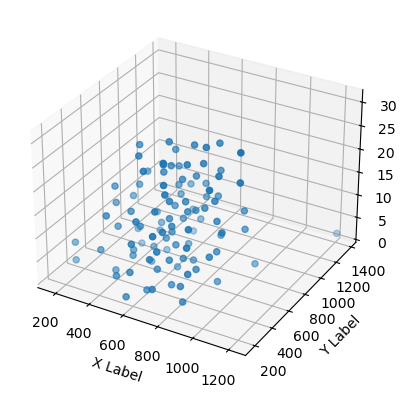

In [84]:
prop_df = prop_df.loc[prop_df["compartments"] == "cytoplasm"]
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    prop_df["centroid-2"],
    prop_df["centroid-1"],
    prop_df["centroid-0"],
    colorizer=prop_df["compartments"],
)
ax.set_xlabel("X Label")
ax.set_ylabel("Y Label")
ax.set_zlabel("Z Label")
plt.show()

In [66]:
# create a function that finds the distance between centroids (3D) of two objects


def find_distance_between_3D_centroids(
    centroid1: Tuple[int, int, int], centroid2: Tuple[int, int, int]
) -> float:

    # calculate the distance between the centroids
    distance = np.sqrt(
        (centroid1[0] - centroid2[0]) ** 2
        + (centroid1[1] - centroid2[1]) ** 2
        + (centroid1[2] - centroid2[2]) ** 2
    )
    return distance

In [ ]:
# relate the compartments to each other via graph based on the centroid distance
# create a graph
G = nx.Graph()
# add the nodes to the graph
G.add_nodes_from(prop_df.index)
# add the edges to the graph
for i, row in prop_df.iterrows():
    for j, row2 in prop_df.iterrows():
        if i != j:
            if row["compartments"] != row2["compartments"]:
                distance = find_distance_between_3D_centroids(
                    (row["centroid-0"], row["centroid-1"], row["centroid-2"]),
                    (row2["centroid-0"], row2["centroid-1"], row2["centroid-2"]),
                )
                G.add_edge(i, j, weight=distance)

NodeNotFound: Source      label  centroid-0  centroid-1   centroid-2  bbox-0  bbox-1  bbox-2  \
57       2    4.112384  236.043793   486.477191       1     109     382   
58       4    1.509065  178.840003   571.863118       1     122     523   
59       7    1.494367  293.670165   839.105291       1     213     702   
60       9    1.492878  300.131045   628.422827       1     229     564   
61      12    2.003344  371.426660   406.432944       1     284     338   
..     ...         ...         ...          ...     ...     ...     ...   
156    245   27.879873  369.356111   698.465699      25     254     617   
157    247   28.448701  623.452610   805.995604      27     556     726   
158    250   27.481764  617.513574   608.350139      27     557     533   
159    252   27.477085  747.931148   822.021507      27     674     744   
160    255   30.496839  561.724792  1024.985191      30     504     966   

     bbox-3  bbox-4  bbox-5 compartments  
57        9     348     597         cell  
58        3     242     626         cell  
59        3     366     950         cell  
60        3     361     725         cell  
61        4     467     784         cell  
..      ...     ...     ...          ...  
156      32     486     778         cell  
157      31     689     878         cell  
158      29     735     708         cell  
159      29     820     898         cell  
160      32     616    1081         cell  

[104 rows x 11 columns] is not in G

In [59]:
def create_bounding_box_array(bbox: np.ndarray, image: np.ndarray) -> np.ndarray:
    # create the a 3D array of zeros
    bounding_box_array = np.zeros_like(image)
    # get the bounding box values
    zmin, ymin, xmin, zmax, ymax, xmax = bbox
    # make the edges of the bounding box 1
    bounding_box_array[zmin:zmax, ymin:ymax, xmin:xmax] = 1

    return bounding_box_array


bounding_box_array = create_bounding_box_array(bbox, nuclei_mask)

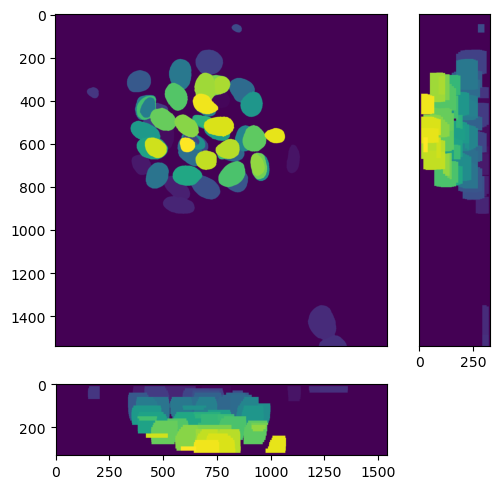

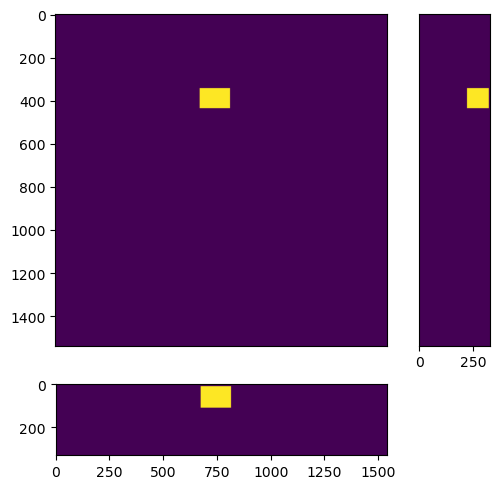

In [61]:
plot_max_ortho_slices(nuclei_mask, anisotropy=10, show_plot=True, plot_output_path=None)
plot_max_ortho_slices(
    bounding_box_array, anisotropy=10, show_plot=True, plot_output_path=None
)

In [23]:
# set mask paths
# load each compartments mask as array